# HeTVAE: Run it, Evaluate it, Test it.

This Jupyter notebook contains all the code and examples to for most things converning HeTVAE. This allows to reproduce experiment results.

In [1]:
from copy import deepcopy
import numpy as np
import torch
import torch.optim as optim
import models
import utils
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

from imputation.hetvae.src.train import HETVAE
from toy_dataset import data_utils
import utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

---

# Get Dataloader

In [2]:
# load my own synthetic data (Josh)
from toy_dataset import data_utils
name = 'toydataset_50000'
path = data_utils.datasets_dict[name]
dataset = data_utils.ToyDataDf(path)
dataset.create_mcar_missingness(0.2, -1)
dataloader_dict = dataset.prepare_data_mtan(batch_size=128)
train_loader = dataloader_dict['train']
gt_train_loader = dataloader_dict['train_ground_truth']
val_loader = dataloader_dict['validation']
gt_validation_loader = dataloader_dict['validation_ground_truth']
test_loader = val_loader
union_tp = utils.union_time(train_loader)
dim = 4

--
Created MCAR missing data, but without missingness in columns Index(['id', 'time'], dtype='object')
missingness_rate: 0.2,	missingness_value: -1
Missing values: 0 out of 4000000 (0.0%) (!excluding aforementioned columns)
Data values in entire dataframe is 6000000 (shape: (1000000, 6))
Attention, missingness_rate = 0 !
Attention, missingness_rate = 0 !
Using batch size 128 for training and validation set.


---
# Loading pretrained HeTVAE model

> Training of HeTVAE model should not take place in Jupyter Notebook (can lead to errors, also dataleakages are common). For training refer to `train_script.py`.

In [3]:
## testing out hetvae trained like physionet
dataset_name = 'toy-josh'
model_args = f'--niters 1000 --lr 0.0001 --batch-size 128 --rec-hidden 128 --latent-dim 128 --width 128 --embed-time 128 --enc-num-heads 1 --num-ref-points 16 --n 8000 --dataset {dataset_name} --seed 1 --save --norm --intensity --net hetvae --bound-variance --shuffle  --sample-tp 0.5 --elbo-weight 1.0 --mse-weight 5.0 --mixing concat --k-iwae 5'



hetvae = HETVAE(dim, union_tp, model_args)

path = '/home2/joshua.wendland/Documents/sepsis/imputation/runs/toy-josh/hetvae/2023.01.24-11.24.44/hetvae.h5'
log_path = '/home2/joshua.wendland/Documents/sepsis/imputation/runs/toy-josh/hetvae/2023.01.24-11.24.44'

hetvae.load_from_checkpoint(path, log_path)

Model args: Namespace(batch_size=128, bound_variance=True, const_var=False, dataset='toy-josh', dropout=0.0, elbo_weight=1.0, embed_time=128, enc_num_heads=1, fname=None, intensity=True, k_iwae=5, kl_annealing=False, kl_zero=False, latent_dim=128, lr=0.0001, mixing='concat', mse_weight=5.0, n=8000, net='hetvae', niters=1000, norm=True, normalize_input='znorm', num_ref_points=16, rec_hidden=128, recon_loss=False, sample_tp=0.5, save=True, seed=1, shuffle=True, std=0.1, var_per_dim=False, width=128)
Logging and saving model to: /home2/joshua.wendland/Documents/sepsis/imputation/runs/toy-josh/hetvae/2023.02.09-09.43.09
self.device: cuda
parameters: 153352
Tensorboard logging to: /home2/joshua.wendland/Documents/sepsis/imputation/runs/toy-josh/hetvae/2023.02.09-09.43.09

Loading model from  /home2/joshua.wendland/Documents/sepsis/imputation/runs/toy-josh/hetvae/2023.01.24-11.24.44/hetvae.h5
Loading saved weights done. Model trained until epoch  249
Tensorboard logging to: /home2/joshua.wen

---


# Visualize a single sample (=a patient)

ground_truth_batch.shape torch.Size([128, 50, 9])
training_batch.shape torch.Size([128, 50, 9])


/home2/joshua.wendland/Documents/sepsis/imputation/hetvae/src/utils.py:512: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x_time, x, alpha=1, marker='x', label='input', facecolor='black', edgecolor='black')


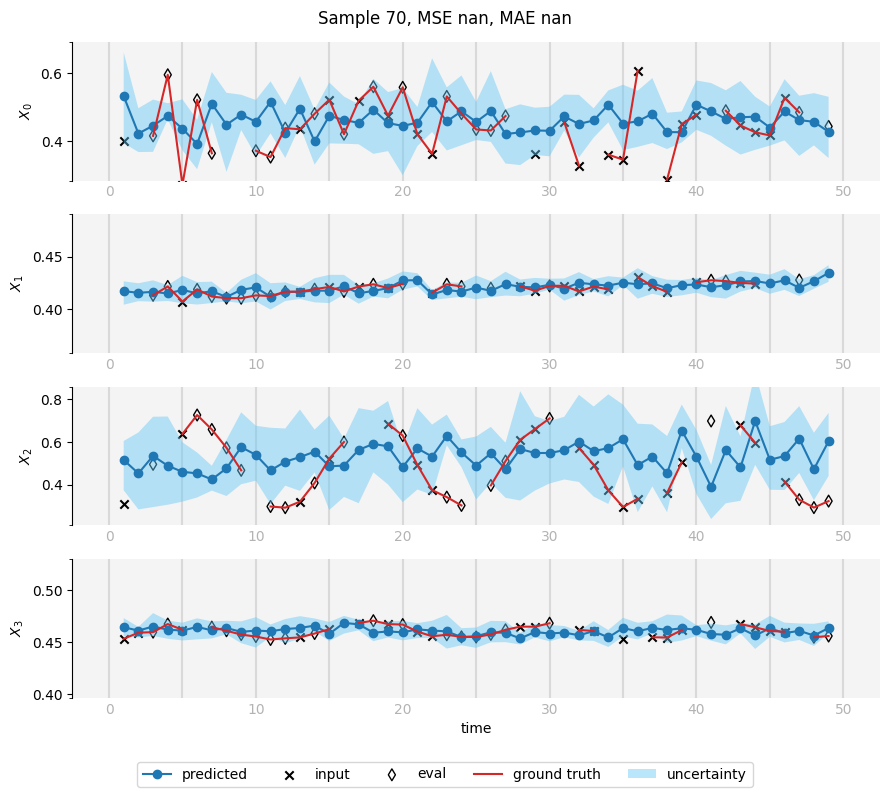

In [85]:
ground_truth_batch, training_batch = data_utils.get_batch_train_ground_truth(train_loader, gt_train_loader, batch_num=0)
print('ground_truth_batch.shape', ground_truth_batch.shape)
print('training_batch.shape', training_batch.shape)
pred_mean, preds, quantile_low, quantile_high, mask_dict = hetvae.impute(training_batch, 200, sample_tp=0.5)
fig = utils.visualize_sample(training_batch, pred_mean, quantile_low, quantile_high, ground_truth_batch, mask_dict, sample=70)

fig.savefig('/home2/joshua.wendland/Documents/sepsis/figures/time_series.svg')

---

# Coverage Rate, Average width, Raw Bias, Percent Bias

The uncertainty of the prediction is visualized in the background as a blue area. 
The area depicts the inner XX percentage of the sampled predictions of x. 
As data most often contains measurement errors, the mean reconstruction of a given input must not necessarily equal the actual input itself, as it might not be the mean/expected value in its condition itself. The input value, however, is expected to lie somewhere in the pdf that our imputation model has predicted for this data point. 
Hence, if we look at the inner XX % of the predicted pdf, in XX % of the cases, the input value should lie within this margin.

+ **Coverage Rate**
+ **Average width**
+ **Raw bias:** We calculate the expected $RB$, $\mathbb E[RB]$. Where $RB(X_\text{pred}, X) = \mathbb E[X_\text{pred}] - X$
+ **Percent bias:** similar to raw bias, but we devide by $X$. So we calculate: $\text{PB}(X_\text{pred}, X) = (\mathbb E[X_\text{pred}] - X) / X$

### Coverage Rate

In [6]:
# calculate coverage ratio and average width
quantiles = np.arange(0.0, 1.1, 0.2)
base_dict = {'coverage_ratio': list(), 'average_width': list()}
CR_AW_dict = {'subsample': deepcopy(base_dict), 'recon': deepcopy(base_dict), 'gt': deepcopy(base_dict)}
sample_tp_CR = 0.9
for q in quantiles:
    # error_dict = data_utils.calculate_cr_aw(hetvae, val_loader, gt_validation_loader, 10, sample_tp=sample_tp_CR, quantile=q)
    error_dict = data_utils.calculate_cr_aw(hetvae, val_loader, gt_validation_loader, 100, sample_tp=sample_tp_CR, quantile=q)
    for data_case in error_dict.keys():
        for metric in error_dict[data_case].keys():
            CR_AW_dict[data_case][metric].append(error_dict[data_case][metric])
        

# make the lists into np.arrays for plotting
for data_case in CR_AW_dict.keys():
    for metric in CR_AW_dict[data_case].keys():
        CR_AW_dict[data_case][metric] = np.stack(CR_AW_dict[data_case][metric], axis=0)

100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


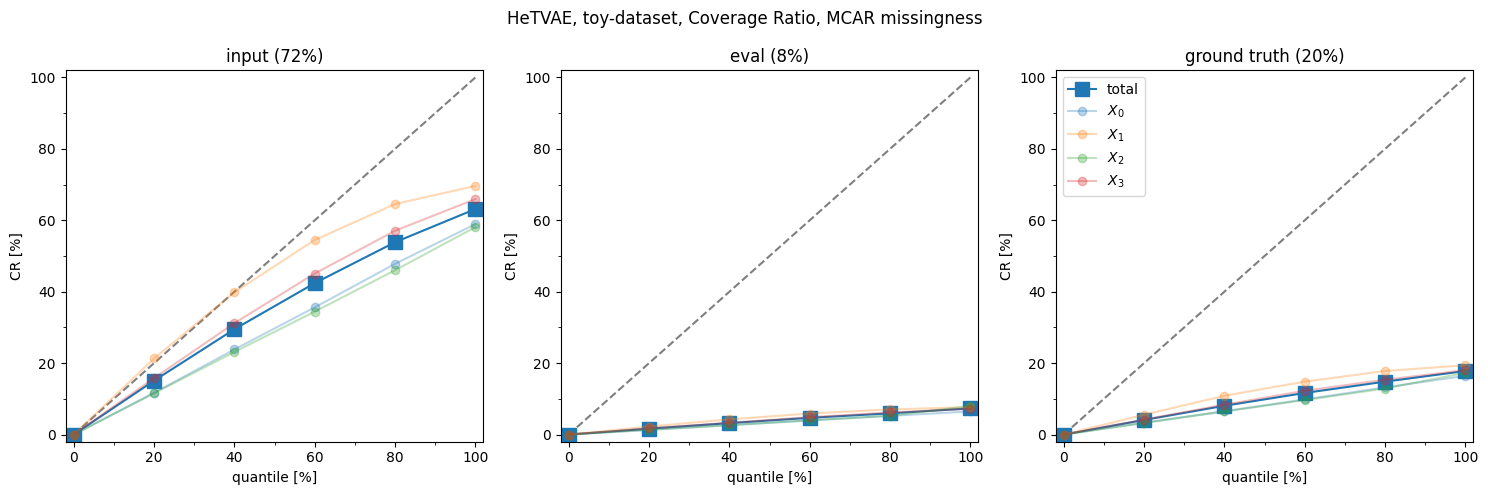

In [7]:
# visualize CR for each data case
metric = 'coverage_ratio'
title_dict = {'gt': f'ground truth ({dataset.artificial_missingness_rate:.0%})',
                'subsample': f'input ({(1-dataset.artificial_missingness_rate)*sample_tp_CR:.0%})',
                'recon': f'eval ({(1-dataset.artificial_missingness_rate)*(1-sample_tp_CR):.0%})'}
num_plots = len(CR_AW_dict.keys())
fig = plt.figure(figsize=(5 * num_plots, 5))
for i, data_case in enumerate(CR_AW_dict.keys()):
    # prepare data
    data = CR_AW_dict[data_case][metric]
    data_mean = data.mean(axis=-1)  # average over all variables
    # plot figure
    ax = fig.add_subplot(1, num_plots, i+1)
    ax.set_title(title_dict[data_case])
    ax.plot([0,100], [0,100], ls='--', color='black', alpha=0.5)
    ax.plot(quantiles * 100, data_mean * 100, marker='s', ms=10, label='total', color='C0')
    for i in range(data.shape[-1]):
        ax.plot(quantiles * 100, data[:,i] * 100, marker='o', alpha=0.3, label=f'$X_{i}$')
        
    ax.set(xlabel='quantile [%]', ylabel='CR [%]', xlim=(-2,102), ylim=(-2,102))
    ax.set_xticks(np.arange(0,100,10), minor=True)
    ax.set_yticks(np.arange(0,100,10), minor=True)
ax.legend()

metric_name = {'coverage_ratio': 'Coverage Ratio', 'average_width': 'Average Width'}
plt.suptitle(f'HeTVAE, toy-dataset, {metric_name[metric]}, MCAR missingness')
plt.tight_layout()
plt.show()

### Bias

In [8]:
# calculate bias
sample_tp_bias = 0.9
bias_dict = data_utils.calculate_bias(hetvae, val_loader, gt_validation_loader, num_samples=100, sample_tp=sample_tp_bias)
print(f'On dataset {dataset.name} and {dataset.artificial_missingness_rate:.1%} missingness.')
for data_case in bias_dict.keys():
    for metric in bias_dict[data_case].keys():
        print(f'{data_case: >9}\t{metric}\t: {bias_dict[data_case][metric]}, mean: {bias_dict[data_case][metric].mean():.6f}')

100%|██████████| 20/20 [00:02<00:00,  8.24it/s]


On dataset Toydataset and 20.0% missingness.
subsample	percent_bias	: [ 0.05112369  0.00291789  0.18351657 -0.00078805], mean: 0.059193
subsample	raw_bias	: [ 0.00363127  0.00114034  0.0019871  -0.00041162], mean: 0.001587
    recon	percent_bias	: [ 0.05478634  0.00501806  0.1909851  -0.00041806], mean: 0.062593
    recon	raw_bias	: [ 0.00417676  0.0012481   0.00456812 -0.00025875], mean: 0.002434
       gt	percent_bias	: [ 0.05096905  0.00268099  0.17377753 -0.00061172], mean: 0.056704
       gt	raw_bias	: [ 0.00329588  0.00105752  0.00050498 -0.00035433], mean: 0.001126


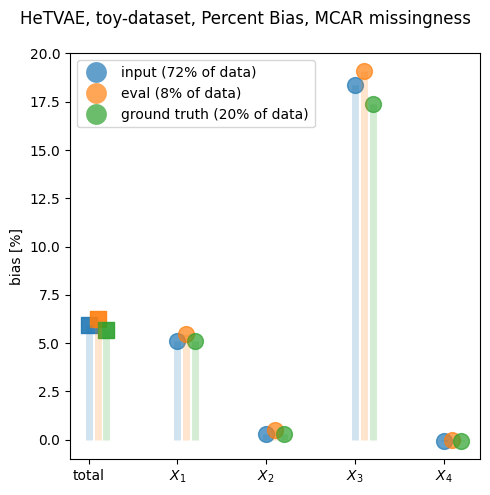

In [9]:
# visualize percent_bias for each data case
metric = 'percent_bias'
title_dict = {'gt': f'ground truth ({dataset.artificial_missingness_rate:.0%} of data)',
                'subsample': f'input ({(1-dataset.artificial_missingness_rate)*sample_tp_bias:.0%} of data)',
                'recon': f'eval ({(1-dataset.artificial_missingness_rate)*(1-sample_tp_bias):.0%} of data)'}
legend_elements = list()
num_plots = len(bias_dict.keys())
num_plots = 1
fig = plt.figure(figsize=(5 * num_plots, 5))
ax = fig.add_subplot(1,1,1)
for j, data_case in enumerate(bias_dict.keys()):
    # prepare data
    data = bias_dict[data_case][metric]
    data_mean = data.mean(axis=-1)  # average over all variables
    x = np.arange(1, len(data)+1)
    dx = 0.1 * j   # offset for the different data_cases
    # plot figure
    # ax = fig.add_subplot(1, num_plots, i+1)
    # ax.set_title(title_dict[data_case])
    ax.vlines(x=0+dx, ymin=0, ymax=data_mean*100, alpha=0.2, linewidth=5, color=f'C{j}')
    ax.scatter(0+dx, data_mean * 100, alpha=0.9, marker='s', s=130, label='total', color=f'C{j}')
    # ax.bar(0, data_mean * 100, alpha=0.9, label='total', color='C0')
    for i in range(data.shape[-1]):
        ax.scatter(x[i]+dx, data[i] * 100, marker='o', s=130, alpha=0.7, label=f'$X_{i}$', color=f'C{j}')
        ax.vlines(x=x[i]+dx, ymin=0, ymax=data[i]*100, alpha=0.2, linewidth=5, color=f'C{j}')
        # ax.bar(x[i], data[i] * 100, alpha=0.5, label=f'$X_{i}$')
        
    ax.set(ylabel='bias [%]', ylim=(-1, 20))
    ax.set_xticks(np.arange(0,5), ['total', '$X_1$', '$X_2$', '$X_3$', '$X_4$'])

    legend_elements.append(matplotlib.lines.Line2D([0], [0], marker='o', color='None', label=title_dict[data_case],
                            markeredgecolor=f'None', alpha=0.7, markerfacecolor=f'C{j}', markersize=15))
# legend
ax.legend(handles=legend_elements, loc='best')



plt.suptitle(f'HeTVAE, toy-dataset, Percent Bias, MCAR missingness')
plt.tight_layout()
plt.show()